# 0.운영체제 과제 01
- 201901763 이지호

- 과제 1
- 마감 : 4월 30일(일) 저녁 6시까지
- 내용 :
    - 수업때 이야기한 모든 스케줄링 방법을 구현하고 성능(5가지) 비교
    - Json 파일로 입력정보를 주면 포맷을 체크해서 비교판단
    - 실시간스케줄링과 비실시간스케줄링을 Json  입력파일로 자동 구분처리
    - 파이썬만 사용, 간트차트 출력을 포함하여 5가지를 모두 비교하고, 각 입력 데이터에 대해 그 중 종합적으로 제일 나은 방법을 "자동" 결과 리포팅 (리포팅 내용을 간단한 설명을 포함하여 자동 생성)
    - 숫자 결과와 그래픽결과를 모두 나타내고 자동으로 리포팅
    - chatGPT 포함한 외부 자료 사용 절대 금함. 특성을 이미 잘 알고 있으므로,  사용흔적이 보이면 0점 처리

    - MarkDown 문서로 설명과 해설 그리고 주석이 포함된 주피터노트북 파일(*.ipynb 파일) 과 해당 파일을 PDF 로 저장한 파일, 입력에 사용하는 json 파일 3개 (입력예제 3개임) 등, 총 5개를 이러닝 사이트에 제출함.

    - 실행 결과는 절대 평가함. (제대로 되었는지 여부, 제출한 입력 포맷에 평가 데이터를 적용해서 진행)
    - 전체 결과는 등급제로 상대 평가함. 열심히 코드 만들고, 열심히 최선의 결과를 잘 만든 사람에게 높은 등급

    - 위 내용을 기준으로 추가로 필요한 부분은 스스로 판단해서 진행하면 됨. 의도에서 벗어나거나 축소되면 안됨.

# 1.분석 준비

## 1.1. Set Value

In [1]:
import copy
import matplotlib.pyplot as plt
import json

- _JSON_NUM_ 변경해가며 출력 가능

In [2]:
_JSON_NUM_ = 1

- 입력할 전체 프로세스들의 시간 길이. 스케쥴링 완료 시 이전에 for문 종료


In [3]:
_MAX_TIME_LENGTH_ = 9999

- Round robin

In [4]:
_DEFAULT_QUANTUM_TIME_ = 20

- print flag

In [5]:
_PRINT_FLAG_ = False
# _PRINT_FLAG_ = True

## 1.2. Load data

In [6]:
def data_loader():
    print("--Data_loader-----------------")
    _jsonfilename = "case" + str(_JSON_NUM_) + ".json"
    with open(_jsonfilename) as f:
        json_object = json.load(f)

    num_of_processs = len(json_object['list'])
    print("- Num of Process :", num_of_processs)

    # data checking
    assert json_object['list']
    for i in range(num_of_processs):
        assert json_object['list'][i]["Num"] > 0
        assert json_object['list'][i]["Burst_time"] > 0
        assert json_object['list'][i]["Priority"] > 0
        assert json_object['list'][i]["Arrival_time"] >= 0
    print("- Data Loading Success")

    return json_object

_DATA_ = data_loader()["list"]


--Data_loader-----------------
- Num of Process : 2
- Data Loading Success


## 1.3. Function
### 1.3.1. draw()


#### 1.3.1.1. Color List
- Process 마다 같은 색으로 시각화 하기 위해 색상표 작성.
- "_COLORS_" 변수 길이 이상의 Process 갯수가 입력 될 시, 랜덤 색상 배정.

In [7]:
file = open("color_list.txt", "r")
_COLORS_ = file.read().splitlines()
file.close()
print("_COLORS_ length is :", len(_COLORS_))

_COLORS_ length is : 117


#### 1.3.1.2. draw Gantt chart
- 프로세스 목록 json 파일 + Order 배열만으로 ploting 일반화 함.
    - ex...
    - Order == [[1, 50], [2, 30], [3, 40]]
    - 1번 프로세스 50, 이후 2번 프로세스 30, 이후 3번 프로세스 40.. 

In [8]:
_ALL_JOB_IS_DONE_ = -999
_NON_PROCESS_ = -1


def draw(_order, _Displaying=True, _period_vector=[], _jop_complete_alram_vector = []):
    ## set print level
    # nothing
    if (_Displaying == False):
        _PRINT_LEVEL_ = 0
    # all information
    elif (_PRINT_FLAG_ == True):
        _PRINT_LEVEL_ = 2
    # simple information
    else:
        _PRINT_LEVEL_ = 1
    if (_PRINT_LEVEL_ > 0):
        print("- Order :", _order)
    if (_PRINT_LEVEL_ > 1):
        print("--Start Analysis--------------")
        
    # init default variable
    fig, ax = plt.subplots(figsize=(10, 1))
    _process = copy.deepcopy(_DATA_)
    _sum_of_busrt_time = 0
    _sum_of_response_time = 0
    _sum_of_turnaround_time = 0
    _sum_of_running_time = 0
    _now_time = 0
    _cumsum_waiting_time = 0
    _xlim_tickers = []

    # 완전동작 카운터
    _start_counter = 0
    _exit_counter = 0

    for _pid, _runtime in _order:
        # NOT CPU RUNNING
        if (_pid < 0):
            # TAKE A REST
            if (_runtime > 0):
                _now_time += _runtime
                continue
            # ALL JOP IS DONE
            elif (_runtime == _ALL_JOB_IS_DONE_):
                break
        # CPU RUNNING
        else:
            # P_num은 1부터 시작하기에, index 맞추는 용도.
            _JUST_PRINT_IDX_ = _pid
            for i in range(len(_process)):
                if (_process[i]['Num'] == _pid):
                    _target = _process[i]
            
            # First come in CPU
            if (_target['Priority'] > 0):
                _sum_of_response_time += _now_time
                if (_PRINT_LEVEL_ > 1):
                    print("START - P", _JUST_PRINT_IDX_, "    time is", _now_time)
                # target의 우선순위에 음수로 시작시간 저장
                # order는 정해져있고, Priority는 이 단계에서 사용하지 않음.
                _target['Priority'] = 0
                _target['Priority'] = - _now_time
                _start_counter += 1
                _xlim_tickers.append(_now_time)
            
            # 통계용 전체 동작 시간 구하기
            _sum_of_busrt_time += _target['Burst_time']
            # 통계용 전체 대기 시간 구하기
            _cumsum_waiting_time += _now_time
            
            # ploting
            ax.barh(0, _runtime, left=_now_time,
                    edgecolor='black', color=_COLORS_[_JUST_PRINT_IDX_-1])
            _now_time += _runtime
            ax.text(_now_time - _runtime/2, 0,
                    ('P'+str(_JUST_PRINT_IDX_)), ha='center', va='center')
            _xlim_tickers.append(_now_time)
            
            # 프로세스 정보에서 진행 시간만큼 차감
            # >> 남은 시간만큼 더 스케줄링하면 됨.
            _target['Burst_time'] -= _runtime
            
            # JOP IS DONE ?
            if (_target['Burst_time'] == 0):
                if (_PRINT_LEVEL_ > 1):
                    print(" P", _JUST_PRINT_IDX_, "Turnaround time is",_now_time - _target['Arrival_time'])
                _sum_of_turnaround_time += _now_time - _target['Arrival_time']
                if (_PRINT_LEVEL_ > 1):
                    print(" P", _JUST_PRINT_IDX_, "Running    time is", _now_time -abs(_target['Priority']))
                _sum_of_running_time += _now_time - abs(_target['Priority'])
                if (_PRINT_LEVEL_ > 1):
                    print("EXIT  - P", _JUST_PRINT_IDX_, "    time is", _now_time)
                    print("")
                _exit_counter +=1
                
    # is_success?
    if (_PRINT_LEVEL_ > 0):
        print("------------------------------")
        if (_start_counter != len(_process)):
            print("START ERROR.. start fault cnt :", len(_process) - _start_counter)
        else:
            print("ALL START GOOD JOB!!!")
        if (_exit_counter != len(_process)):
            print("EXIT  ERROR.. exit  complete cnt :", len(_process) - _exit_counter)
        else:
            print("ALL EXIT  GOOD JOB!!!")
    # ploting
    # _period_vector = [number, period]
    _last_xlim_ticker = _xlim_tickers[-1]
    # 각 벡터마다 gantt chart 끝까지 주기 티거 생성하기
    for _num, _period in _period_vector:
        # 제일 끝 티거 * 1.1 길이까지 period 티커 생성
        for _now_time in range(int(_last_xlim_ticker * 1.2)):
            # 0초 이상이고, 주기 도래할 때마다 적기
            if(_now_time % _period == 0 and _now_time > 0):
                # 각 period마다 서로 다른 높이 지정
                _height = _period_vector.index([_num, _period])
                # 누구의 period인지?
                ax.text(_now_time, 0.6+_height*0.2,
                        ('P'+str(_num)), ha='center', va='center')
                # 누가 어디서 주기가 도래하는지?
                _xlim_tickers.append(_now_time)
    # x_ticker 중복 제거
    _xlim_tickers = list(set(_xlim_tickers))
    ax.set_xticks(_xlim_tickers)
    ax.set_xlim([0, _now_time])
    ax.set_yticks([])
    
    for _num, _complete_time in _jop_complete_alram_vector:
        ax.text(_complete_time, -0.2,
                (str(_num)), ha='center', va='center')
    
    if (_PRINT_LEVEL_ > 0):
        plt.show()
    
    _ans = dict()
    # cpu 이용률
    _ans['CPU_utilization'] = float(_sum_of_busrt_time/_now_time*100)
    # 단위 시간당 처리된 프로세스의 개수
    _ans['Throughput'] = len(_process)/_now_time
    # 프로세스를 cpu가 실행하지 않은 평균 대기시간
    _ans['Average_waiting_time'] = _cumsum_waiting_time/len(_process)
    # 프로세스를 처음으로 실행하는 데에 걸린 시간
    _ans['Average_Response_time'] = _sum_of_response_time/len(_process)
    # 처음 대기 부터, 작업 완료에 대한 총 소요 시간 / p's 종료시점 - arrival_time
    _ans['Average_Turnaround_time'] = _sum_of_turnaround_time/len(_process)
    # 시작하고 나서부터 완료까지 걸린 시간
    _ans['Average_Running_time'] = _sum_of_running_time/len(_process)
    # print value
    if (_PRINT_LEVEL_ > 1):
        for _subject, _value in _ans.items():
            if (_subject == 'CPU_utilization'):
                print(_subject, ": %2.2f" % _value, "%")
            elif (_subject == 'Throughput'):
                print(_subject, ": %2.4f" % _value)
            else:
                print(_subject, ":", _value)
    
    return _ans


### 1.3.3. is_complete()
- 해당 list에 들은 burst time의 합이 0인지 판단하기


In [9]:
def is_complete(_list):
    _sum_of_all_burst_time = 0
    for i in _list:
        _sum_of_all_burst_time += i['Burst_time']
    if (_sum_of_all_burst_time == 0):
        return True
    else:
        return False

### 1.3.3. order_zip()
- order 압축기
- [5, 1]. [5, 1],..을 [5, 2]로 압축해줌

In [10]:
def order_zip(_order):
    _idx = 0
    while (_idx < len(_order)):
        # 만약 종료 지점 만나면 무한루프 탈출
        if (_order[_idx+1] == [_NON_PROCESS_, _ALL_JOB_IS_DONE_]):
            break
        # 만약 같은 프로세스의 작업지시 만나면 합체
        elif (_order[_idx][0] == _order[_idx + 1][0]):
            _order[_idx + 1][1] += _order[_idx][1]
            _order.pop(_idx)
        # 다른 프로세스 만난거면 다음 process 압축하러 넘어감
        else:
            _idx += 1
    return _order

# 2.Non Real-time Scheduling


## 2.1. First-come, First-Served
- 기본 Arrival_time 정렬, 동일 시간 도착 시 프로세스 번호 순

- Order : [[2, 35], [-1, 15], [1, 25], [-1, -999]]
------------------------------
ALL START GOOD JOB!!!
ALL EXIT  GOOD JOB!!!


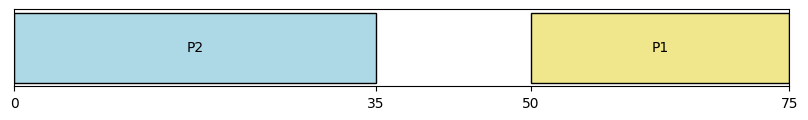

In [11]:
def FCFO(_list, _Displaying=True):
    _order = []

    _list = sorted(_list, key=lambda x: x['Arrival_time'])

    _end_time = 0
    # arrival_time 고려해야하니 timer 작동
    for _now_time in range(_MAX_TIME_LENGTH_):
        # 만약 모든 Burst_time 합이 0이면 모든 작업이 종료된 것
        # 다만 마지막 작업 추가했을 때와, _now_time간 오차있음.
        if (is_complete(_list) == True):
            _order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])
            break
        # 아직 안 끝남.
        else:
            # 노는 중
            if (_end_time < _now_time):
                # take a rest 1sec == timer speed
                _order.append([_NON_PROCESS_, 1])
                _end_time += 1
                
            # 현재 시간에 도착해있는 작업들 리스트업
            for _process in _list:
                if (_process['Arrival_time'] == _now_time):
                    _order.append([_process['Num'], _process['Burst_time']])
                    _end_time += _process['Burst_time']
                    _process['Burst_time'] = 0
    _order = order_zip(_order)
    if (_Displaying == True):
        draw(_order, _Displaying)
    return _order

_list = copy.deepcopy(_DATA_)
_tmp = FCFO(_list)


## 2.2. Shortest-Job-First


### 2.2.1. SJF
- 기본 Arrival_time 정렬, 동일 시간 도착 시 프로세스 번호 순
- Arrival_time 시점 기준, Burst_time만 고려

- Order : [[2, 35], [-1, 15], [1, 25], [-1, -999]]
------------------------------
ALL START GOOD JOB!!!
ALL EXIT  GOOD JOB!!!


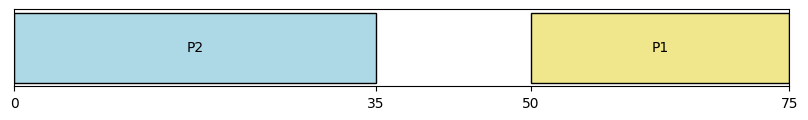

In [12]:
def SJF(_list, _Displaying=True):
    _order = []
    _list = sorted(_list, key=lambda x: x['Arrival_time'])

    _end_time = 0
    # arrival_time 고려해야하니 timer 작동
    for _now_time in range(_MAX_TIME_LENGTH_):
        # 만약 모든 Burst_time 합이 0이면 모든 작업이 종료된 것
        # 다만 마지막 작업 추가했을 때와, _now_time간 오차있음.
        if (is_complete(_list) == True):
            _order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])
            break
        # 아직 안 끝남.
        else:
            # 노는 중
            if (_end_time < _now_time):
                # take a rest 1sec == timer speed
                _order.append([_NON_PROCESS_, 1])
                _end_time += 1
                
            # 현재 시간에 도착해있는 작업들 리스트업
            _queue = []
            for _process in _list:
                if (_process['Arrival_time'] == _now_time):
                    _queue.append(_process)
            
            # 정렬 후 order에 추가    
            _queue.sort(key=lambda x: x['Burst_time'])
            for _process in _queue:
                _order.append([_process['Num'], _process['Burst_time']])
                _end_time += _process['Burst_time']
                _process['Burst_time'] = 0
    
    _order = order_zip(_order)
    if (_Displaying == True):
        draw(_order, _Displaying)
    return _order


_list = copy.deepcopy(_DATA_)
_tmp = SJF(_list)


### 2.2.2. Preemptive_SJF
- 기본 Arrival_time 정렬, 동일 시간 도착 시 프로세스 번호 순
- Arrival_time 시점 기준, Burst_time만 고려
- 단, Burst_time 짧은 process 도착 시, 이것으로 대체 됨.

- Order : [[2, 35], [-1, 15], [1, 25], [-1, -999]]
------------------------------
ALL START GOOD JOB!!!
ALL EXIT  GOOD JOB!!!


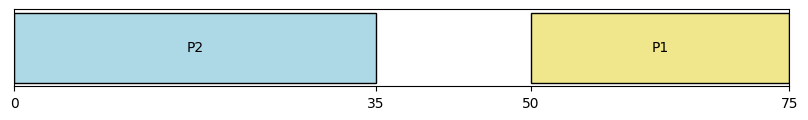

In [13]:
def Preemptive_SJF(_list, _Displaying=True):
    _order = []
    _list = sorted(_list, key=lambda x: x['Arrival_time'])
    #########################
    # round robin이나 선점형에선 작업 추가 후 다시 볼 일이 있기 때문에 해당 변수 초기화하면 안 됨.
    _queue = []
    #########################
    _end_time = 0
    # arrival_time 고려해야하니 timer 작동
    for _now_time in range(_MAX_TIME_LENGTH_):

        # 만약 모든 Burst_time 합이 0이면 모든 작업이 종료된 것
        # 다만 마지막 작업 추가했을 때와, _now_time간 오차있음.
        if (is_complete(_list) == True):
            _order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])
            break
        # 아직 안 끝남.
        else:
            # 노는 중
            if (_end_time < _now_time):
                # take a rest 1sec == timer speed
                _order.append([_NON_PROCESS_, 1])
                _end_time += 1

            # 현재 시간에 도착해있는 작업들 리스트업
            for _process in _list:
                if (_process['Arrival_time'] == _now_time):
                    _queue.append(_process)
            # 아무 작업도 없으면 다음 for로 넘어감
            if(len(_queue) == 0):
                continue
            # _now_time 마다 큐에서 스케쥴링
            # (1) 일단 앞에서부터 burst_time == 0 인 프로세스 있을 때 마다 다음 실행을 위해 인덱스 넘어감
            _idx = 0
            while (_queue[_idx]['Burst_time'] == 0):
                # index 넘어가는데, 도착 목록들에 남은 것 있으면 넘기기
                if (is_complete(_queue) == False):
                    _idx += 1
                # 미도착 목록 존재하면 idx넘어가지 않음. out of range error있음.
                else:
                    break
            
            # 원래의 burst_time 순으로 정렬하기
            _compare_queue = copy.deepcopy(_DATA_)
            _compare_queue = [tmp for tmp in _compare_queue if tmp['Num'] in [q['Num'] for q in _queue]]
            _compare_queue.sort(key=lambda x: x['Burst_time'])
            
            # (2) 원래 짧은 시간이 누구인가 찾았음. 그 프로세스는 _queue에서는 시간이 줄어든 채로 있을 것임.
            # 그 줄어든 burst_time을 가지는 친구를 _queue에서 찾아야함. >> _idx가 찾은 결과
            for i in range(len(_queue)):
                if (_compare_queue[0]['Num'] == _queue[i]['Num'] and _queue[i]['Burst_time'] != 0):
                    _idx = i
                    
            # (1)과 (2)에서 정해진 인덱스 둘 중 하나로 스케쥴링한다.
            _process = _queue[_idx]
            if (_process['Burst_time'] > 0):
                if (_process['Burst_time'] - 1 >= 0):
                    _order.append([_process['Num'], 1])
                    _end_time += 1
                    _process['Burst_time'] -= 1
    _order = order_zip(_order)
    if (_Displaying == True):
        draw(_order, _Displaying)
    return _order

_list = copy.deepcopy(_DATA_)
_tmp = Preemptive_SJF(_list)


### 2.2.3. Preemptive_SRJF
- 기본 Arrival_time 정렬, 동일 시간 도착 시 프로세스 번호 순
- Arrival_time 시점 기준, 잔여 Burst_time 고려
- 단, 잔여 Burst_time 짧은 process 발견 시, 이것으로 대체 됨.

- Order : [[2, 35], [-1, 15], [1, 25], [-1, -999]]
------------------------------
ALL START GOOD JOB!!!
ALL EXIT  GOOD JOB!!!


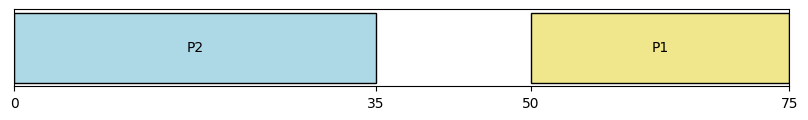

In [14]:
def Preemptive_SRJF(_list, _Displaying=True):
    _order = []
    _list = sorted(_list, key=lambda x: x['Arrival_time'])
    #########################
    # round robin이나 선점형에선 작업 추가 후 다시 볼 일이 있기 때문에 해당 변수 초기화하면 안 됨.
    _queue = []
    #########################
    _end_time = 0
    # arrival_time 고려해야하니 timer 작동
    for _now_time in range(_MAX_TIME_LENGTH_):

        # 만약 모든 Burst_time 합이 0이면 모든 작업이 종료된 것
        # 다만 마지막 작업 추가했을 때와, _now_time간 오차있음.
        if (is_complete(_list) == True):
            _order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])
            break
        # 아직 안 끝남.
        else:
            # 노는 중
            if (_end_time < _now_time):
                # take a rest 1sec == timer speed
                _order.append([_NON_PROCESS_, 1])
                _end_time += 1

            # 현재 시간에 도착해있는 작업들 리스트업
            for _process in _list:
                if (_process['Arrival_time'] == _now_time):
                    _queue.append(_process)
            # 아무 작업도 없으면 다음 for로 넘어감
            if (len(_queue) == 0):
                continue
            # 남은 burst_time 순으로 정렬하기
            _queue.sort(key=lambda x: x['Burst_time'])
            # _now_time 마다 큐에서 스케쥴링
            _idx = 0
            while (_queue[_idx]['Burst_time'] == 0):
                # index 넘어가는데, 도착 목록들에 남은 것 있으면 넘기기
                if (is_complete(_queue) == False):
                    _idx += 1
                # 미도착 목록 존재하면 idx넘어가지 않음. out of range error있음.
                else:
                    break

            _process = _queue[_idx]
            if (_process['Burst_time'] > 0):
                if (_process['Burst_time'] - 1 >= 0):
                    _order.append([_process['Num'], 1])
                    _end_time += 1
                    _process['Burst_time'] -= 1

    _order = order_zip(_order)
    if (_Displaying == True):
        draw(_order, _Displaying)
    return _order

_list = copy.deepcopy(_DATA_)
_tmp = Preemptive_SRJF(_list)


## 2.3. Priority First Served

### 2.3.1. Priority
- 기본 Arrival_time 정렬, 동일 시간 도착 시 프로세스 번호 순
- Priority 고려, 우선 순위 동일 시 프로세스 번호 순

- Order : [[2, 35], [-1, 15], [1, 25], [-1, -999]]
------------------------------
ALL START GOOD JOB!!!
ALL EXIT  GOOD JOB!!!


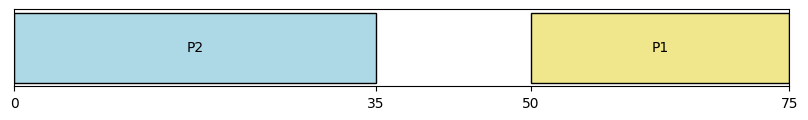

In [15]:
def Priority(_list, _Displaying=True):
    _order = []
    _list = sorted(_list, key=lambda x: x['Arrival_time'])

    _end_time = 0
    # arrival_time 고려해야하니 timer 작동
    for _now_time in range(_MAX_TIME_LENGTH_):
        # 만약 모든 Burst_time 합이 0이면 모든 작업이 종료된 것
        # 다만 마지막 작업 추가했을 때와, _now_time간 오차있음.
        if (is_complete(_list) == True):
            _order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])
            break
        # 아직 안 끝남.
        else:
            # 노는 중
            if (_end_time < _now_time):
                # take a rest 1sec == timer speed
                _order.append([_NON_PROCESS_, 1])
                _end_time += 1

            # 현재 시간에 도착해있는 작업들 리스트업
            _queue = []
            for _process in _list:
                if (_process['Arrival_time'] == _now_time):
                    _queue.append(_process)

            # 정렬 후 order에 추가
            _queue.sort(key=lambda x: x['Priority'])
            for _process in _queue:
                _order.append([_process['Num'], _process['Burst_time']])
                _end_time += _process['Burst_time']
                _process['Burst_time'] = 0
    _order = order_zip(_order)
    if (_Displaying == True):
        draw(_order, _Displaying)
    return _order

_list = copy.deepcopy(_DATA_)
_tmp = Priority(_list)


### 2.3.2. Preemptive_Priority
- 기본 Arrival_time 정렬, 동일 시간 도착 시 프로세스 번호 순
- Priority 고려, 우선 순위 동일 시 프로세스 번호 순
- 단, 더 높은 우선 순위 process 발견 시 이것으로 대체 됨.

- Order : [[2, 35], [-1, 15], [1, 25], [-1, -999]]
------------------------------
ALL START GOOD JOB!!!
ALL EXIT  GOOD JOB!!!


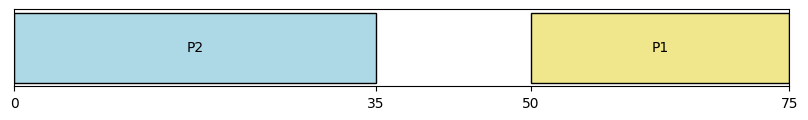

In [16]:
def Preemptive_Priority(_list, _Displaying=True):
    _order = []
    _list = sorted(_list, key=lambda x: x['Arrival_time'])
    #########################
    # round robin이나 선점형에선 작업 추가 후 다시 볼 일이 있기 때문에 해당 변수 초기화하면 안 됨.
    _queue = []
    #########################
    _end_time = 0
    # arrival_time 고려해야하니 timer 작동
    for _now_time in range(_MAX_TIME_LENGTH_):

        # 만약 모든 Burst_time 합이 0이면 모든 작업이 종료된 것
        # 다만 마지막 작업 추가했을 때와, _now_time간 오차있음.
        if (is_complete(_list) == True):
            _order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])
            break
        # 아직 안 끝남.
        else:
            # 노는 중
            if (_end_time < _now_time):
                # take a rest 1sec == timer speed
                _order.append([_NON_PROCESS_, 1])
                _end_time += 1

            # 현재 시간에 도착해있는 작업들 리스트업
            for _process in _list:
                if (_process['Arrival_time'] == _now_time):
                    _queue.append(_process)
            # 아무 작업도 없으면 다음 for로 넘어감
            if (len(_queue) == 0):
                continue
            # 남은 Priority 순으로 정렬하기
            _queue.sort(
                key=lambda x: x['Priority'])

            # _now_time 마다 큐에서 스케쥴링
            _idx = 0
            while (_queue[_idx]['Burst_time'] == 0):
                # index 넘어가는데, 도착 목록들에 남은 것 있으면 넘기기
                if (is_complete(_queue) == False):
                    _idx += 1
                # 미도착 목록 존재하면 idx넘어가지 않음. out of range error있음.
                else:
                    break

            _process = _queue[_idx]
            if (_process['Burst_time'] > 0):
                if (_process['Burst_time'] - 1 >= 0):
                    _order.append([_process['Num'], 1])
                    _end_time += 1
                    _process['Burst_time'] -= 1

    _order = order_zip(_order)
    if (_Displaying == True):
        draw(_order, _Displaying)
    return _order


_list = copy.deepcopy(_DATA_)
_tmp = Preemptive_Priority(_list)


## 2.4. Round robin
- 기본 Arrival_time 정렬, 동일 시간 도착 시 프로세스 번호 순
- QUANTUM_TIME 내에 처리하지 못 할 경우, 남은 Burst_time은 큐의 맨 뒤로 감.

### 2.4.1. Round Robin

- Order : [[2, 35], [-1, 15], [1, 25], [-1, -999]]
------------------------------
ALL START GOOD JOB!!!
ALL EXIT  GOOD JOB!!!


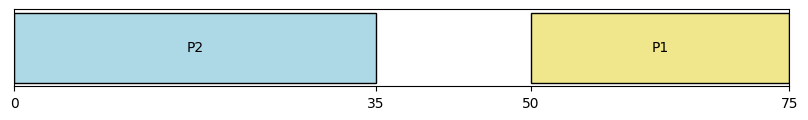

In [17]:
# RR 수정본
def RR(_list, _Displaying=True, _usr_quantum_time=_DEFAULT_QUANTUM_TIME_):
    _order = []
    _QUANTUM_TIME_ = _usr_quantum_time
    _list = sorted(_list, key=lambda x: x['Arrival_time'])
    #########################
    # round robin이나 선점형에선 작업 추가 후 다시 볼 일이 있기 때문에 해당 변수 초기화하면 안 됨.
    _queue = []
    #########################
    _remain_quantum_time = 0
    # arrival_time 고려해야하니 timer 작동
    for _now_time in range(_MAX_TIME_LENGTH_):
        # 만약 모든 Burst_time 합이 0이면 모든 작업이 종료된 것
        # 다만 마지막 작업 추가했을 때와, _now_time간 오차있음.
        if (is_complete(_list) == True):
            _order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])
            break
        # 아직 안 끝남.
        else:
            # 현재 시간에 도착해있는 작업들 리스트업
            for _process in _list:
                if (_process['Arrival_time'] == _now_time):
                    _queue.append(_process)
            # # 오더 가능 횟수가 0회일 경우 >> 모두 배정했거나, 아무도 못받아서 대기하고있었거나
            # if (_remain_quantum_time == 0):
            #     # 퀀텀타임 주기 or 대기 종료 시 우선순위기반 재정렬함
            #     _queue.sort(key=lambda x: x['Priority'])
            # 만약 비어있는데, 남아있으면, 대기 1초
            if (_queue == [] and is_complete(_list) == False):
                _order.append([_NON_PROCESS_, 1])
            # 실행할 프로세스 있으면,
            else:
                # 우선순위 기반 재정렬이 된 직후 >> 한 프로세스에 대해
                # 오더 가능 시간 지정
                if (_remain_quantum_time == 0):
                    _remain_quantum_time = _QUANTUM_TIME_
                # 그리고 오더 1초씩 추가
                _order.append([_queue[0]['Num'], 1])
                # 남은 burst_time 1초 삭감
                _queue[0]['Burst_time'] -= 1
                # 남은 오더 가능 횟수 1회 삭감
                _remain_quantum_time -= 1
                # 만약 몇초 안 남아서 퀀텀타임보다 일찍 끝나면?
                if (_queue[0]['Burst_time'] == 0):
                    # 기능종료와 큐에서 삭제
                    _remain_quantum_time = 0
                    _queue.pop(0)
                # 만약 퀀텀타임을 다 사용하면?
                elif (_remain_quantum_time == 0):
                    # 큐의 맨 뒤로 돌려보냄
                    _queue.append(_queue.pop(0))

    _order = order_zip(_order)
    if (_Displaying == True):
        draw(_order, _Displaying)
    return _order


_list = copy.deepcopy(_DATA_)
_tmp = RR(_list, True, 4)


### 2.4.2. Priority + Round robin
- 기본 Arrival_time 정렬, 동일 시간 도착 시 프로세스 번호 순
- QUANTUM_TIME 내에 처리하지 못 할 경우, 남은 Burst_time은 큐의 맨 뒤로 감.
- Priority 고려, 우선 순위 동일 시 프로세스 번호 순

- Order : [[2, 35], [-1, 15], [1, 25], [-1, -999]]
------------------------------
ALL START GOOD JOB!!!
ALL EXIT  GOOD JOB!!!


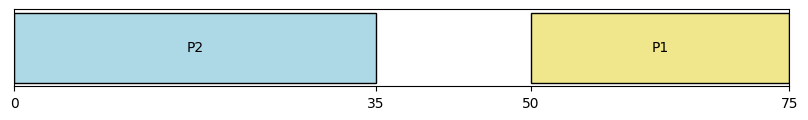

In [18]:
def Priority_RR(_list, _Displaying=True, _usr_quantum_time=_DEFAULT_QUANTUM_TIME_):
    _order = []
    _QUANTUM_TIME_ = _usr_quantum_time
    _list = sorted(_list, key=lambda x: x['Arrival_time'])
    #########################
    # round robin이나 선점형에선 작업 추가 후 다시 볼 일이 있기 때문에 해당 변수 초기화하면 안 됨.
    _queue = []
    #########################
    _remain_quantum_time = 0
    # arrival_time 고려해야하니 timer 작동
    for _now_time in range(_MAX_TIME_LENGTH_):
        # 만약 모든 Burst_time 합이 0이면 모든 작업이 종료된 것
        # 다만 마지막 작업 추가했을 때와, _now_time간 오차있음.
        if (is_complete(_list) == True):
            _order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])
            break
        # 아직 안 끝남.
        else:
            # 현재 시간에 도착해있는 작업들 리스트업
            for _process in _list:
                if (_process['Arrival_time'] == _now_time):
                    _queue.append(_process)
            # 오더 가능 횟수가 0회일 경우 >> 모두 배정했거나, 아무도 못받아서 대기하고있었거나
            if(_remain_quantum_time == 0):
                # 퀀텀타임 주기 or 대기 종료 시 우선순위기반 재정렬함
                _queue.sort(key=lambda x: x['Priority'])
            # 만약 비어있는데, 남아있으면, 대기 1초
            if (_queue == [] and is_complete(_list) == False):
                    _order.append([_NON_PROCESS_, 1])
            # 실행할 프로세스 있으면,
            else:
                # 우선순위 기반 재정렬이 된 직후 >> 한 프로세스에 대해
                # 오더 가능 시간 지정
                if (_remain_quantum_time == 0):
                    _remain_quantum_time = _QUANTUM_TIME_
                # 그리고 오더 1초씩 추가
                _order.append([_queue[0]['Num'], 1])
                # 남은 burst_time 1초 삭감
                _queue[0]['Burst_time'] -= 1
                # 남은 오더 가능 횟수 1회 삭감
                _remain_quantum_time -= 1
                # 만약 몇초 안 남아서 퀀텀타임보다 일찍 끝나면?
                if (_queue[0]['Burst_time'] == 0):
                    # 기능종료와 큐에서 삭제
                    _remain_quantum_time = 0
                    _queue.pop(0)
                # 만약 퀀텀타임을 다 사용하면?
                elif (_remain_quantum_time == 0):
                    # 큐의 맨 뒤로 돌려보냄
                    _queue.append(_queue.pop(0))
                    
    _order = order_zip(_order)
    if (_Displaying == True):
        draw(_order, _Displaying)
    return _order

_list = copy.deepcopy(_DATA_)
_tmp = Priority_RR(_list, True, 4)


## 2.5. Multi Level Queue
- 스케줄링 함수 호출 시, 2번째 파라미터로 False 주면 출력 아예 없음.

### 2.5.1. Multi Level Queue


- Order : [[2, 35], [-1, 15], [1, 25], [-1, -999]]
------------------------------
ALL START GOOD JOB!!!
ALL EXIT  GOOD JOB!!!


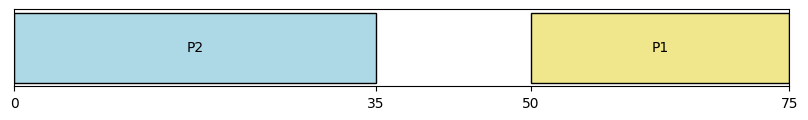

In [19]:
def Multi_level_queue(_list, _quantum_time=10):
    _order = []
    # 서로다른 priority 갯수 세기
    _unique_priorities = set()
    for process in _list:
        _unique_priorities.add(process['Priority'])
    # index 나중에 필요해서 list로 전환
    _unique_priorities = list(_unique_priorities)
    _unique_priorities = sorted(_unique_priorities)
    # create level empty queue
    _level = []
    # print(_unique_priorities)
    for i in range(len(_unique_priorities)):
        _level.append([])
        # 동일 레벨 갯수대로 각각 level_queue 생성하기
    for _target_priority in _unique_priorities:
        for i in range(len(_list)):
            if (_list[i]['Priority'] == _target_priority):
                _level[_unique_priorities.index(
                    _target_priority)].append(_list[i])
    # print(_level)
    #####################################################################    
    ## 각자 레벨에서 각기 다른 방식으로 스케쥴링 된 것들이, 선점형 우선순위 스케쥴링 되어야함.
    # each level scheduling
    _level_complete = []
    for i in range(len(_unique_priorities)):
        if(i == 0):
            _level_complete.append(Priority_RR(
                _level[i], False, _quantum_time))
        elif(i == 1):
            _level_complete.append(Priority_RR(
                _level[i], False, _quantum_time))
        elif (i == 2):
            _level_complete.append(Preemptive_SRJF(_level[i], False))
        elif (i == 3):
            _level_complete.append(Preemptive_SRJF(_level[i], False))
        elif (i == 4):
            _level_complete.append(SJF(_level[i], False))
        else:
            _level_complete.append(FCFO(_level[i], False))
    #####################################################################
    ### 우선순위 기반 큐 간 스케쥴링 
    for _now_time in range(_MAX_TIME_LENGTH_):
        # 하위 우선순위부터 _now_time에 실행할 것을 갱신함.
        # 제일 마지막에 갱신된 것이 가장 높은 우선순위 & 실행가능한 프로세스임.
        _now_order = [-1,1]
        for _each_level in reversed(_level_complete):
            # queue의 맨 앞이 뭐든 비었으면 pop
            if (_each_level[0][1] == 0):
                _each_level.pop(0)
            # queue의 맨 앞이 프로세스고, 진행 가능하면 진행할 것임
            if(_each_level[0][0] != _NON_PROCESS_):
                _now_order[0] = _each_level[0][0]
            # queue의 맨 앞이 non-process
            else:
                _each_level[0][1] -= 1
            # print(_now_time, _now_order, _each_level)
        # _now_order가 프로세스일 경우 해당하는 것만 시간 줄여야함    
        # _now_order가 정해진 다음에 수행해야함.
        if(_now_order[0] != _NON_PROCESS_):
            for _each_level in _level_complete:
                # 해당 프로세스 찾을 시
                if (_now_order[0] == _each_level[0][0]):
                    _each_level[0][1] -= 1
                
        ## 스케줄링 이후 시점        
        ## 여기서 999 끊어내야함.
        _end_flag = True
        for _each_level in _level_complete:
            if(_each_level[0][1] > _ALL_JOB_IS_DONE_):
                _end_flag = False
        if(_end_flag == True):
            _order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])
            break
        else:
            _order.append(_now_order)
        
    # order 압축        
    _order = order_zip(_order)
    draw(_order, True)

_list = copy.deepcopy(_DATA_)
Multi_level_queue(_list, 30)


### 2.5.2. Multi Level Feedback Queue

- Order : [[2, 35], [-1, 15], [1, 25], [-1, -999]]
------------------------------
ALL START GOOD JOB!!!
ALL EXIT  GOOD JOB!!!


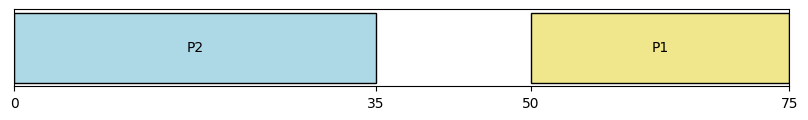

In [20]:
def is_empty_list(_levels):
    is_empty = True
    for i in range(len(_levels)):
        if _levels[i]:
            is_empty = False
            break
    return is_empty

def Multi_level_feedback_queue(_list, _level1 = 8, _level2 = 16):
    _order = []

    _list = sorted(_list, key=lambda x: x['Arrival_time'])

    # 각 quantum 8, 16, FCFO
    _levels = [[],[],[]]
    _LEVEL_1_QUANTUM_TIME_ = _level1
    _LEVEL_2_QUANTUM_TIME_ = _level2
    #####################################################################
    # 우선순위 기반 큐 간 스케쥴링
    for _now_time in range(_MAX_TIME_LENGTH_):
        # 만약 모든 Burst_time 합이 0이면 모든 작업이 종료된 것
        # # 다만 마지막 작업 추가했을 때와, _now_time간 오차있음.
        if (is_complete(_list) == True):
            _order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])
            break
        # 현재 시간에 도착해있는 작업들 리스트업
        for _process in _list:
            if (_process['Arrival_time'] == _now_time):
                _levels[0].append(_process)
                _levels[0][-1]['Priority'] = _LEVEL_1_QUANTUM_TIME_
        ###############################################################
        # 하나도 도착 안 했으면 >> wait

        if (is_empty_list(_levels) == True):
            _order.append([_NON_PROCESS_, 1])
            
        # 기본 세팅 끝. 이하 levels 존재 가정함.
        else:
            ###########################
            ### 비진 않았는데, 1단계에 없는 경우
            # 2 > 1
            if(_levels[0]==[] and _levels[1] != []):
                # 이미 level2큐 다녀왔을때엔 선입선출 해줌
                if (_levels[1][0]['Priority'] == _LEVEL_2_QUANTUM_TIME_):
                    _levels[1][0]['Priority'] = _levels[1][0]['Burst_time']
                # 처음 올라온거면 level2 제한시간 줌
                else:
                    _levels[1][0]['Priority'] = _LEVEL_2_QUANTUM_TIME_
                _levels[0].append(_levels[1].pop(0))
            # 3 > 2 // 선입선출 : 자기 남은 실행시간 다 제공해줌
            elif (_levels[0] == [] and _levels[1] == [] and _levels[2] != []):
                _levels[2][0]['Priority'] = _levels[2][0]['Burst_time']
                _levels[1].append(_levels[2].pop(0))
                # 마찬가지로 2 > 1은 두 배 시간 줌
                if (_levels[0] == [] and _levels[1] != []):
                    _levels[0].append(_levels[1].pop(0))
                    # 잔여 burst time 이미 배정되어있음.
            ###########################
            ######## 1단계에 존재하는 경우
            _now_process = _levels[0][0]
            # 배정받은 러닝타임 있는 동안 실행
            if (_now_process['Priority'] > 0):
                # 할당 시간 오더에 추가하고
                _order.append([_now_process['Num'], 1])
                # 일단 시간 줄이고 다음 큐에 대입
                _now_process['Burst_time'] -= 1
                _now_process['Priority'] -= 1
            # 빈 프로세서 발견하면 다 치워버리고 카운터 초기화
            if (_now_process['Burst_time'] == 0):
                _levels[0].pop(0)
            # 아래 elif는, 잔여시간 0이상이고, 배정시간 끝난 경우
            elif (_now_process['Priority'] == 0):
                # 한 단계 널널한 시간줌.
                _levels[0][0]['Priority'] = _LEVEL_2_QUANTUM_TIME_
                _levels[1].append(_levels[0].pop(0))
            # print(_now_time, _now_process['Priority'], _levels)
        
    _order = order_zip(_order)
    draw(_order, True)

_list = copy.deepcopy(_DATA_)
Multi_level_feedback_queue(_list, 80, 100)


# 3.Real-Time scheduling

## 3.1. Rate-Monotonic
- period가 짧은 프로세스가 높은 우선순위를 가짐.
- 단위 시간 당, 프로세스의 수행 비율과 우선순위 간의 관계를 고려함
- 모든 프로세스는 부팅과 동시에 주기를 갖고 실행된다고 가정 -> 오로지 Burst_time과 period만 필요.

- Order : [[2, 35], [1, 25], [-1, 20], [2, 35], [-1, 35], [1, 10], [2, 35], [1, 15], [-1, 30], [2, 35], [-1, 25], [-1, -999]]
------------------------------
ALL START GOOD JOB!!!
ALL EXIT  GOOD JOB!!!


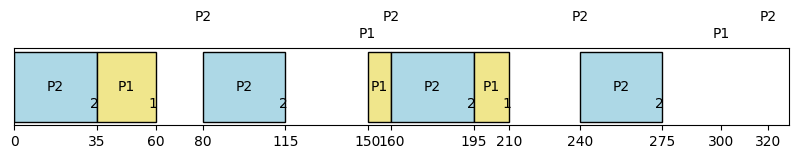

In [21]:
from math import gcd


def lcm_solution(arr):
    def lcm(x, y):
        return x * y // gcd(x, y)

    while True:
        arr.append(lcm(arr.pop(), arr.pop()))
        if len(arr) == 1:
            return arr[0]

def Rate_Monotonic(_list):
    # burst_time copy
    _original_list = copy.deepcopy(_list)
    # 완료 판단할 것인데, index 기반 접근 위해 num 기준 sort
    _original_list = sorted(_original_list, key=lambda x: x['Num'])
    _pass_list = set()
    # rate-monotonic이 성립할지?
    # 각자 모두가 0초부터 자신의 period 내에 1번이라도 실행되었는가 판단하면 됨.
    # can_to_this에서 period와 now_time을 비교하는데, burst_time 남아있으면 다 못한 것
    _order = []
    
    # _period_vector는 우선순위로 정렬해서 줘야함.
    _period_vector = []
    _jop_complete_alram_vector = []

    # 가장 긴 주기 2배 만큼 플로팅
    _periods = []
    for _process in _list:
        _period_vector.append([_process['Num'], _process['Period']])
        _periods.append(_process['Period'])
    
    for _now_time in range(max(_periods)*2):
                
        # period 주기가 도래할 때마다 그 프로세서를 큐에 추가함
        for _process in _original_list:
            if (_now_time % _process['Period'] == 0 and _now_time > 0):
                _add_this_jop = copy.deepcopy(_process)
                _list.append(_add_this_jop)
        
        # period에 기반한 우선순위 설정
        if(_list == []):
            # 비어있을 시 대기시간 추가
            _order.append([_NON_PROCESS_, 1])
            continue
        else:
            # 우선순위 별 정렬
            _list = sorted(_list, key=lambda x: x['Period'])
            # 오더 추가
            _order.append([_list[0]['Num'], 1])
            # 진행 상황 반영
            _list[0]['Burst_time'] -= 1
            # 모두 진행 되었으면, 큐에서 삭제
            if (_list[0]['Burst_time'] == 0):
                _jop_complete_alram_vector.append([_list[0]['Num'], _now_time])
                _list.pop(0)
        
        # 주기 안에 실행완료 성공했는지 확인하는 코드
        for _complete_process, _when in _jop_complete_alram_vector:
            # 1 주기 돌았을 때에만 검사함.
            # 만약 그게 pass list에 없으면
            if _complete_process not in _pass_list:
                # 근데 완료 시점이 추기보다 짧으면
                if (_when <=_original_list[_complete_process-1]['Period']):
                    # pass 확인요
                    _pass_list.add(_complete_process)
                    pass
                # 근데 추기보다 길다면, 걔때문에 rate-monotonic 불가
                else:
                    print("CAN'T TO THIS")
                    print(_now_time)
                    print("running failed process :", _complete_process)
                    return 
    # 종료 플래그 삽입
    _order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])
    _order = order_zip(_order)
    
    draw(_order, True, _period_vector, _jop_complete_alram_vector)
    
_list = copy.deepcopy(_DATA_)
Rate_Monotonic(_list)

## 3.2. EDF (Earliest Deadline Fiest)

lcm 1200
p_num : 1 .. 1200 divided by 150 = 8 == cnt 8 is ok
p_num : 2 .. 1200 divided by 80 = 15 == cnt 15 is ok
- Order : [[2, 35], [1, 25], [-1, 20], [2, 35], [-1, 35], [1, 10], [2, 35], [1, 15], [-1, 30], [2, 35], [-1, 25], [1, 20], [2, 35], [1, 5], [-1, 40], [2, 35], [-1, 15], [1, 25], [-1, 5], [2, 35], [-1, 45], [2, 35], [-1, 5], [1, 25], [-1, 15], [2, 35], [-1, 45], [2, 35], [1, 25], [-1, 20], [2, 35], [-1, 45], [2, 35], [1, 25], [-1, 20], [2, 35], [-1, 45], [2, 35], [1, 25], [-1, 20], [2, 35], [-1, 45], [2, 35], [1, 25], [-1, 20], [2, 35], [-1, 35], [1, 10], [2, 35], [1, 15], [-1, 30], [2, 35], [-1, 25], [1, 20], [2, 35], [1, 5], [-1, 40], [2, 35], [-1, 15], [1, 25], [-1, 5], [2, 35], [-1, 45], [2, 35], [-1, 5], [1, 25], [-1, 15], [2, 35], [-1, 45], [2, 35], [1, 25], [-1, 20], [2, 35], [-1, 45], [2, 35], [1, 25], [-1, 20], [2, 35], [-1, 45], [2, 35], [1, 25], [-1, 20], [2, 35], [-1, 45], [-1, -999]]
------------------------------
ALL START GOOD JOB!!!
ALL EXIT  GOOD JOB!!!


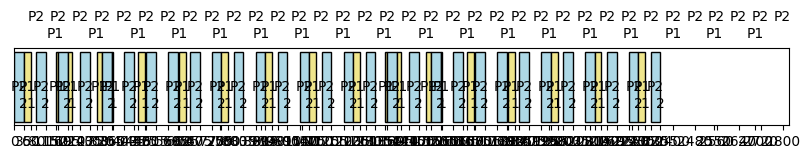

In [22]:
def EDF(_list):
    # burst_time copy
    _original_list = copy.deepcopy(_list)
    # 완료 판단할 것인데, index 기반 접근 위해 num 기준 sort
    _original_list = sorted(_original_list, key=lambda x: x['Num'])

    _order = []

    # _period_vector는 우선순위로 정렬해서 줘야함.
    _period_vector = []
    _jop_complete_alram_vector = []

    # 가장 긴 주기 2배 만큼 플로팅
    _periods = []
    _complete_counter = []
    for _process in _list:
        _period_vector.append([_process['Num'], _process['Period']])
        _complete_counter.append(0)
        _periods.append(_process['Period'])

    # 최소공배수 구하기
    _lcm = lcm_solution(_periods)

    if (_MAX_TIME_LENGTH_ < _lcm):
        print("계산 보증 불가능. 주기들의 최소공배수 시간에서 정상횟수 작동 확인 불가. MAX_TIME_LENGTH 늘리고 다시시도.")
        print(_lcm, "여기까지 시도해봐야 정확히 RTOS 구현 가능 여부 알 수 있음.")

    for _now_time in range(max(_periods)*2):

        # period 주기가 도래할 때마다 그 프로세서를 큐에 추가함
        for _process in _original_list:
            if (_now_time % _process['Period'] == 0 and _now_time > 0):
                _add_this_jop = copy.deepcopy(_process)
                _list.append(_add_this_jop)

        # period에 기반한 우선순위 설정
        if (_list == []):
            # 비어있을 시 대기시간 추가
            _order.append([_NON_PROCESS_, 1])
            continue
        else:
            # 우선순위 별 정렬
            _list = sorted(_list, key=lambda x: x['Period'])
            ###################################
            # 데드라인 얼마 안 남은 놈을 _list 맨 앞으로 보내면 됨.
            # 1. 데드라인 제일 가까운 놈을 구해야함.
            _i_want_complete = 0
            _min_remain_time = _MAX_TIME_LENGTH_
            # 모든 list의 프로세스에서
            for _process in _list:
                # dead_line까지 남은 시간 구하기
                _remain_time = (_process['Period'] -
                                _now_time % _process['Period'])
                # 이번 process의 dead_line이 가장 짧았다면 갱신
                if (_remain_time < _min_remain_time):
                    _min_remain_time = _remain_time
                    _i_want_complete = _process
                # print(_now_time, _remain_time, _process)
            # 2. 걔만 맨 앞으로. (데드라인 순 정렬 안 해도, 어차피 매 순간 적게 남은 프로세스만 앞으로 옴)
            _list.remove(_i_want_complete)
            _list.insert(0, _i_want_complete)
            ###################################
            # 오더 추가
            _order.append([_list[0]['Num'], 1])
            # 진행 상황 반영
            _list[0]['Burst_time'] -= 1
            # 모두 진행 되었으면, 큐에서 삭제
            if (_list[0]['Burst_time'] == 0):
                _jop_complete_alram_vector.append([_list[0]['Num'], _now_time])
                _complete_counter[_list[0]['Num']-1] += 1
                _list.pop(0)

        # 최소공배수 안에 완료가능한가.
        if (_now_time == _lcm):
            print("lcm", _now_time)
            for _process in _original_list:
                if (_now_time / _process['Period'] <= _complete_counter[_process['Num']-1]):
                    print("p_num :", _process['Num'], "..", _lcm, "divided by", _process['Period'], '=', int(
                        _now_time / _process['Period']), "== cnt", _complete_counter[_process['Num']-1], "is ok")
                else:
                    print("p_num :", _process['Num'], "CAN'T DO THIS")
                    print("force exit..")
                    return

    # 종료 플래그 삽입
    _order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])
    _order = order_zip(_order)

    draw(_order, True, _period_vector, _jop_complete_alram_vector)


_list = copy.deepcopy(_DATA_)
EDF(_list)

#######################
# 해당 스케쥴링 불가한 경우, 진행 불가하단 메시지 출력함.
